# Evaluation

In [ ]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from utils import plot, evaluation
import numpy as np

c:\Users\mijin\Documents\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ml_eval_df = pd.DataFrame(columns=['method', 'mae', 'mse', 'rmse', 'r2', 'adjusted_r2'])
si_eval_df = pd.DataFrame(columns=['method', 'mae', 'mse', 'rmse', 'r2', 'adjusted_r2'])

ml_bin_eval_df = pd.DataFrame(columns=['method', 'dis_bin', 'mae', 'mse', 'rmse', 'r2', 'adjusted_r2'])
si_bin_eval_df = pd.DataFrame(columns=['method', 'dis_bin', 'mae', 'mse', 'rmse', 'r2', 'adjusted_r2'])

ml_error_df = pd.DataFrame(columns=['dis_bin', 'method', 'y_true', 'y_pred', 'error'])
si_error_df = pd.DataFrame(columns=['dis_bin', 'method', 'y_true', 'y_pred', 'error'])

## Autogluon best model Evaluation

- boxplot: dis_bin-wise distribution, error distribution
- barplot: dis_bin-wise rmse, adjusted_r2
- output: csv
- model: 모델 별로 가장 성능이 좋은 것만 선택
    - CatBoost
    - ExtraTrees
    - KNeighbors
    - LightGBM
    - NeuralNetFastAI
    - NeuralNetTorch
    - WeightedEnsemble
    - RandomForest
    - XGBoost

In [ ]:
test_df = pd.read_csv('data/241026_Rockhead_Seoul_test(before_aumentation).csv')

In [4]:
test = TabularDataset(test_df.drop(['dis_bin'], axis=1))

In [ ]:
predictor = TabularPredictor.load('AutogluonModels\\ag-20241027_050358')
ld_board = predictor.leaderboard(test, silent=True)

Found 1 mismatches between original and current metadata:
	INFO: AutoGluon Python micro version mismatch (original=3.11.9, current=3.11.8)


In [6]:
model_list = ['CatBoost', 'ExtraTrees', 'KNeighbors', 'LightGBM', 'NeuralNetFastAI', 'NeuralNetTorch', 'RandomForest', 'WeightedEnsemble', 'XGBoost']

In [7]:
best_model_list = []

for i in range(len(ld_board)):

    for model_type in model_list:

        if model_type in ld_board.model[i]:
            best_model_list.append(ld_board.model[i])
            model_list.remove(model_type)

print(best_model_list)

['WeightedEnsemble_L3', 'NeuralNetTorch_r135_BAG_L2', 'NeuralNetFastAI_r145_BAG_L2', 'LightGBM_r188_BAG_L2', 'ExtraTrees_r42_BAG_L2', 'RandomForest_r15_BAG_L2', 'KNeighborsDist_BAG_L1', 'XGBoost_r33_BAG_L1', 'CatBoost_r128_BAG_L1']


In [ ]:
for model in best_model_list:
    
    error_df = pd.DataFrame(columns=['dis_bin', 'method', 'y_true', 'y_pred', 'error'])

    for bin in test_df['dis_bin'].unique():

        bin_df = test_df[test_df['dis_bin'] == bin]
                                
        X_test_bin = TabularDataset(bin_df.drop(['depth_start', 'dis_bin'], axis=1))
        y_test_bin = bin_df['depth_start'].array

        pred_y = predictor.predict(X_test_bin, model)

        error = {'dis_bin':np.full(y_test_bin.shape, bin), 'method':np.full(y_test_bin.shape, model),'y_true':y_test_bin, 'y_pred':pred_y, 'error':y_test_bin-pred_y}
        error_df = pd.concat([error_df, pd.DataFrame(error)], ignore_index=True)

        mae, mse, rmse, r2, adjusted_r2 = plot.evaluation(y_test_bin, pred_y, len(y_test_bin), 7)
        ml_bin_eval_df.loc[len(ml_bin_eval_df)] = (model, bin, mae, mse, rmse, r2, adjusted_r2)

    ml_error_df = pd.concat([ml_error_df, error_df], ignore_index=True)
    
    mae, mse, rmse, r2, adjusted_r2 = evaluation.metrics(error_df['y_true'], error_df['y_pred'], len(error_df), 7)
    ml_eval_df.loc[len(ml_eval_df)]=(model, mae, mse, rmse, r2, adjusted_r2)

C:\Users\mijin\AppData\Local\Temp\ipykernel_17484\3238297096.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_df = pd.concat([error_df, pd.DataFrame(error)], ignore_index=True)
C:\Users\mijin\AppData\Local\Temp\ipykernel_17484\3238297096.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ml_error_df = pd.concat([ml_error_df, error_df], ignore_index=True)
C:\Users\mijin\AppData\Local\Temp\ipykernel_17484\3238297096.py:15: FutureWarning: The behavior of DataFrame concatenation with emp

KeyboardInterrupt: 

In [ ]:
ml_eval_df.to_csv('data/241027_AutoML_top5_Evaluation(before_aumentation).csv', index=False)

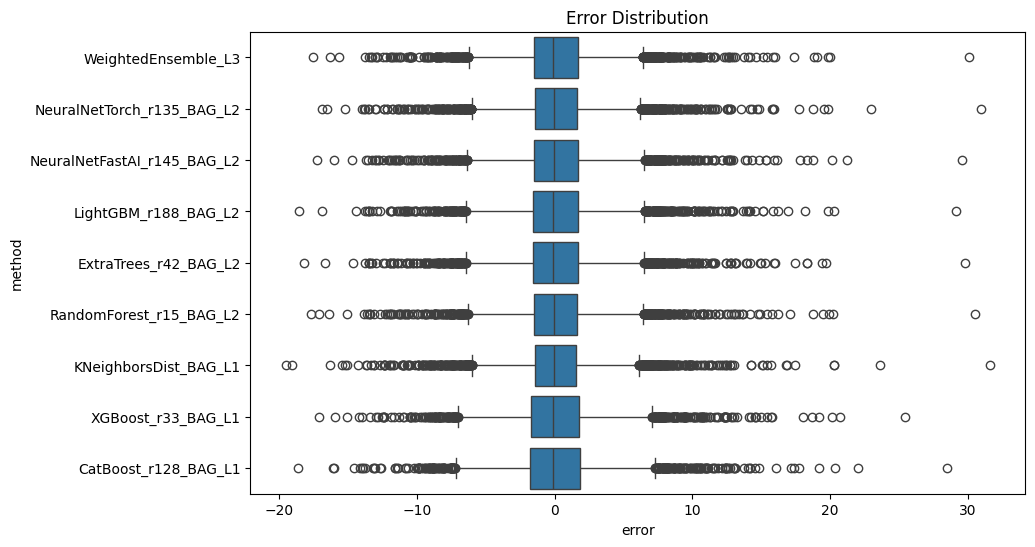

In [ ]:
# method-wise error distribution
plot.distribution_plot(ml_error_df, 'error', 'method', 'Error Distribution')

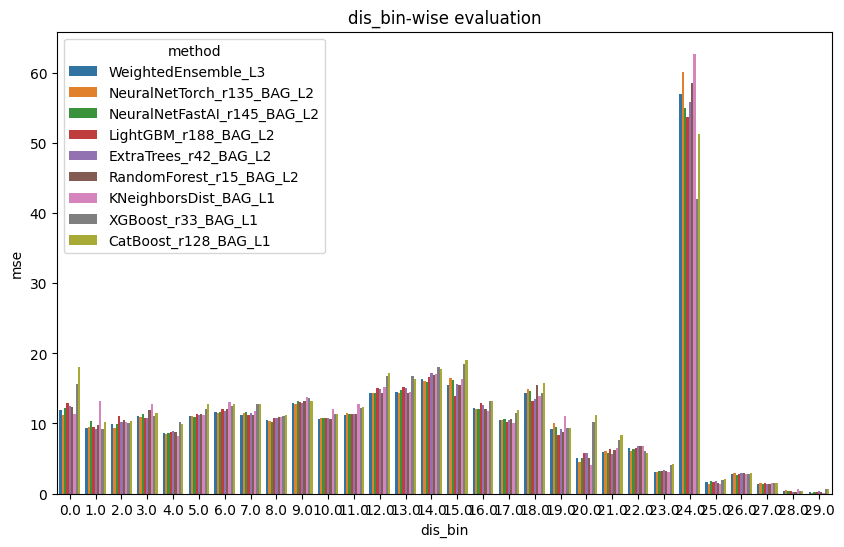

In [ ]:
# dis_bin-wise evaluation
plot.barplot(ml_bin_eval_df, 'dis_bin', 'mse', 'dis_bin-wise evaluation', hue='method')

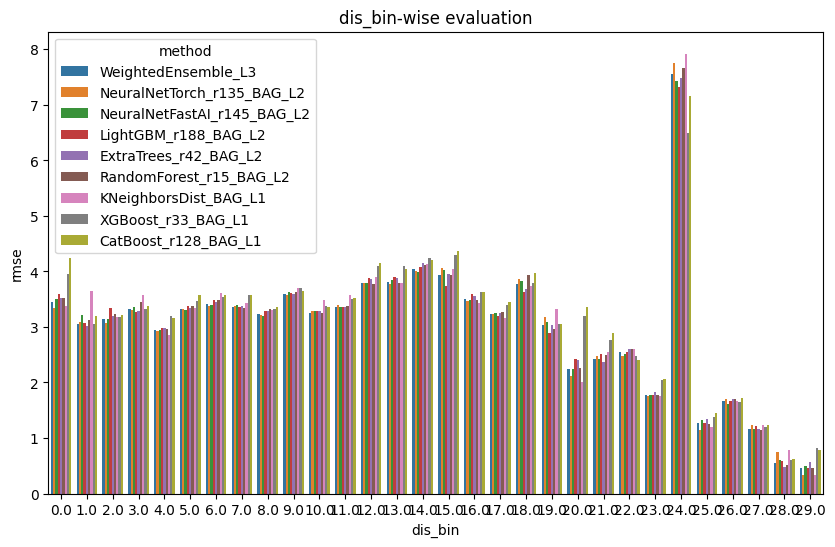

In [ ]:
# dis_bin-wise evaluation
plot.barplot(ml_bin_eval_df, 'dis_bin', 'rmse', 'dis_bin-wise evaluation', hue='method')

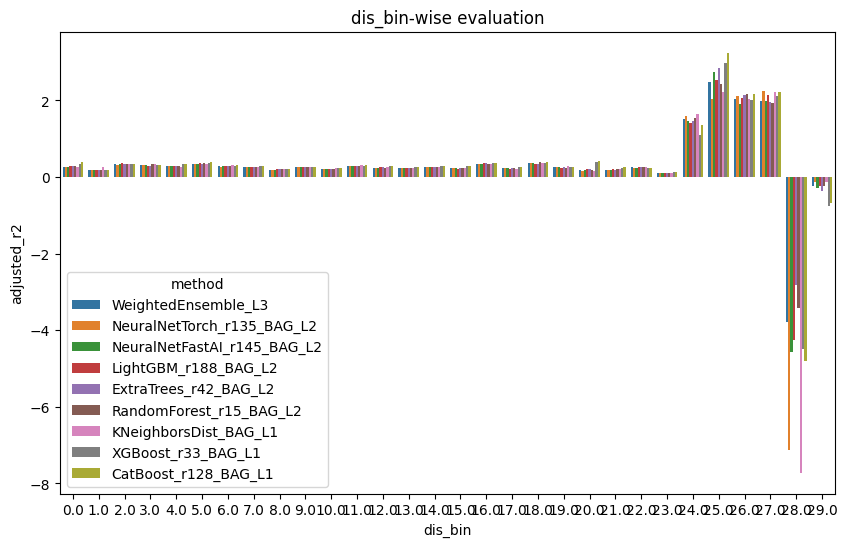

In [ ]:
# dis_bin-wise evaluation
plot.barplot(ml_bin_eval_df, 'dis_bin', 'adjusted_r2', 'dis_bin-wise evaluation', hue='method')

In [ ]:
plot.prediction_plot(ml_error_df, 'y_true', 'y_pred', 'dis_bin')

## Spatial Interpolation Method Evaluation

- boxplot: dis_bin-wise distribution, error distribution
- output: csv

1. Spatial Interpolation with Networks

    - GNNWR [Geographically neural network weighted regression for the accurate estimation of spatial non-stationarity](https://doi.org/10.1080/13658816.2019.1707834)

    - KCN [Kriging Convolutional Networks](https://doi.org/10.48550/arXiv.2306.09463)

    - GSARNN [A generalized spatial autoregressive neural network method for three-dimensional spatial interpolation](https://doi.org/10.5194/gmd-16-2777-2023)

    - DKNN [DKNN: deep kriging neural network for interpretable geospatial interpolation](https://doi.org/10.1080/13658816.2024.2347316)

2. Simple Spatial Interpolation

    - Kriging [PyKrige](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/)

    - KNN [scikit-learn-Nearest Neighbors regression](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html)

    - RBF [Scipy-RBf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf)

    - IDW

In [ ]:
test_df = pd.read_csv('data/241026_Rockhead_Seoul_test(before_aumentation).csv')

In [ ]:
for i in range(8):
        
    for bin in test_df['dis_bin'].unique():

        error_df = pd.DataFrame(columns=['bin', 'method', 'y_true', 'y_pred', 'error'])

        bin_df = test_df[test_df['dis_bin'] == bin]
                                
        # X_test_bin = TabularDataset(bin_df.drop(['depth_start', 'dis_bin'], axis=1))
        # y_test_bin = bin_df['depth_start'].array

        # pred_y = predictor.predict(X_test_bin, ld_board.model[i])

        error = {'bin':np.full(y_test_bin.shape, bin), 'method':np.full(y_test_bin.shape, ld_board.model[i]),'y_true':y_test_bin, 'y_pred':pred_y, 'error':abs(y_test_bin-pred_y)}
        error_df = pd.concat([error_df, pd.DataFrame(error)], ignore_index=True)

        si_error_df = pd.concat([si_error_df, error_df], ignore_index=True)
    
    mae, mse, rmse, r2, adjusted_r2 = evaluation.metrics(error_df['y_true'], error_df['y_pred'], len(error_df), 7)
    result={'method':, 'mae':mae, 'mse':mse, 'rmse':rmse, 'r2':r2, 'adjusted_r2':adjusted_r2}
    si_eval_df = pd.concat([si_eval_df, pd.DataFrame(result)], ignore_index=True)

In [ ]:
si_eval_df.to_csv('data/241027_Spatial_Interpolation_Evaluation(before_aumentation).csv', index=False)

In [ ]:
# method-wise error distribution
plot.boxplot_2(si_error_df, 'error', 'method', 'Error Distribution')

In [ ]:
# dis_bin-wise error distribution
plot.barplot(si_eval_df, 'bin', 'RMSE', 'distribution', hue='method')
plot.barplot(si_eval_df, 'bin', 'adjusted_r2', 'distribution', hue='method')

## Comparison Autogloun Model, Spatial Interpolation Method

- multi-barplot: dis_bin

In [ ]:
error_df = pd.concat([ml_error_df, si_error_df], ignore_index=True)
evaluation_df = pd.concat([ml_eval_df, si_eval_df], ignore_index=True)

In [ ]:
# method-wise error distribution
plot.boxplot_2(si_error_df, 'error', 'method', 'Error Distribution')

In [ ]:
# dis_bin-wise error distribution
plot.barplot(si_eval_df, 'bin', 'RMSE', 'distribution', hue='method')
plot.barplot(si_eval_df, 'bin', 'adjusted_r2', 'distribution', hue='method')

## Surface Visualization
- contour map
- 3d map

In [ ]:
map_df = pd.read_csv('data/241026_Rockhead_Seoul_map(before_aumentation).csv')

In [ ]:
plot.contour_plot()

In [ ]:
plot.surface_3d()